# Quantum syndrome decoder

Classical LDPC matrices are stored in "files/[name].npy" from working directory

The notation used here will borrow from the following blog post [here](https://arthurpesah.me/blog/2022-05-21-classical-error-correction/)


In [47]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import gradio as gr
import time
from itertools import combinations


In [48]:
file1  = 'Dv2Dc3_G18_N114.npy'
file2  = 'Dv2Dc6_G8_N36.npy'

#classical
CM1 = np.load('files/'+file1)
CM2 = np.load('files/'+file2)

In [49]:
surface25 = np.array([[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]],dtype=int)



In [50]:
def gaussianElimination(matrix, columns=None, diagonalize=True,
                        successfulCols=None, q=2):
        """
        gaussianElimination(matrix, columns=None, diagonalize=True, successfulCols=None, q=2)

        The Gaussian elimination algorithm in :math:`\mathbb F_q` arithmetics, turning a given
        matrix into reduced row echelon form by elementary row operations.

        .. warning:: This algorithm operates **in-place**!

        Parameters
        ----------
        matrix : np.int_t[:,::1]
            The matrix to operate on.
        columns : np.intp_t[:], optional
            A sequence of column indices, giving the the order in which columns of the matrix are
            visited. Defaults to ``range(matrix.shape[1])``.
        diagonalize : bool, True
            If ``True``, matrix elements above the pivots will be turned to zeros, leading to a
            diagonal submatrix. Otherwise, the result contains an upper triangular submatrix.
        successfulCols : np.intp_t[::1], optinonal
            Numpy array in which successfully diagonalized column indices are stored. If supplied,
            this array will be used for the return value. Otherwise, a new array will be created,
            resulting in a slight performance drain.
        q : int, optional
            Field size in which operations should be performed. Defaults to ``2``.

        Returns
        -------
        np.intp_t[::1]
            Indices of successfully diagonalized columns.
        """
        nrows = matrix.shape[0]
        ncols = matrix.shape[1]
        curRow = 0
        colIndex = 0
        numSuccessfulCols = 0
        # assert q < cachedInvs.shape[0]

        if successfulCols is None:
            successfulCols = np.empty(nrows, dtype=np.intp)
        if columns is None:
            columns = np.arange(ncols, dtype=np.intp)
        while True:
            if colIndex >= columns.shape[0]:
                break
            curCol = columns[colIndex]
            # search for a pivot row
            pivotRow = -1
            for row in range(curRow, nrows):
                val = matrix[row, curCol]
                if val != 0:
                    pivotRow = row
                    break
            if pivotRow == -1:
                # did not find a pivot row -> this column is linearly dependent of the previously
                # visited; continue with next column
                colIndex += 1
                continue
            if pivotRow > curRow:
                # swap rows
                for i in range(ncols):
                    val = matrix[curRow, i]
                    matrix[curRow, i] = matrix[pivotRow, i]
                    matrix[pivotRow, i] = val
            # do the actual pivoting
            if matrix[curRow, curCol] > 1:
                # "divide" by pivot element to set it to 1
                if q > 2:
                    factor = cachedInvs[q, matrix[curRow, curCol]]
                    for i in range(ncols):
                        matrix[curRow, i] = (matrix[curRow, i] * factor) % q
            for row in range(curRow + 1, nrows):
                val = matrix[row, curCol]
                if val != 0:
                    for i in range(ncols):
                        if q == 2:
                            matrix[row, i] ^= matrix[curRow, i]
                        else:
                            matrix[row, i] =  (matrix[row, i] -val*matrix[curRow, i]) % q
            successfulCols[numSuccessfulCols] = curCol
            numSuccessfulCols += 1
            if numSuccessfulCols == nrows:
                break
            curRow += 1
            colIndex += 1
        if diagonalize:
            for colIndex in range(numSuccessfulCols):
                curCol = successfulCols[colIndex]
                for row in range(colIndex):
                    val = matrix[row, curCol]
                    if val != 0:
                        for i in range(ncols):
                            if q == 2:
                                matrix[row, i] ^= matrix[colIndex, i]
                            else:
                                matrix[row, i] = (matrix[row, i] - val*matrix[colIndex, i]) % q
        return successfulCols[:numSuccessfulCols]

def rank(matrix, q=2):
    """Return the rank (in GF(q)) of a matrix."""
    diagCols = gaussianElimination(matrix.copy(), diagonalize=False, q=q)
    return diagCols.size

def orthogonalComplement(matrix, columns=None, q=2):
    """Computes an orthogonal complement (in GF(q)) to the given matrix."""
    matrix = np.asarray(matrix.copy())
    m, n = matrix.shape
    unitCols = gaussianElimination(matrix, columns, diagonalize=True, q=q)
    nonunitCols = np.array([x for x in range(n) if x not in unitCols])
    rank = unitCols.size
    nonunitPart = matrix[:rank, nonunitCols].transpose()
    k = n - rank
    result = np.zeros((k, n), dtype=np.int32)
    for i, c in enumerate(unitCols):
        result[:, c] = (-nonunitPart[:, i]) % q
    for i, c in enumerate(nonunitCols):
        result[i, c] = 1
    return result


def convert(strings, leng, plural=True, alpha=True):
    """given a string of stabilizers and number of encoding qubits, convert into 2d array parity check matrix"""
    if plural:
        total = len(strings)
    else:
        total = 1
    stabilizers = np.zeros([total,leng],dtype=int)
    filler=[]
    if alpha:
        match_x = 'X'
        match_z = 'Z'
        #match_y = 'Y'
    else:
        match_x = '1'
        match_z = '1'
    length = leng
    stabilizers =np.zeros([total,leng],dtype=int)
    for i in range(total):
        curr_stab = np.zeros((length,),dtype=int)
        for j in range(leng):
            if plural:
                if strings[i][j]==match_x:
                    curr_stab[j]=1
                elif strings[i][j]==match_z:
                    curr_stab[j]=1
                else:
                    curr_stab[j]=0
            else:
                if strings[j]==match_x:
                    curr_stab[j]=1
                elif strings[j]==match_z:
                    curr_stab[j]=1
                else:
                    curr_stab[j]=0
        stabilizers[i]=curr_stab
    return stabilizers  

## Tools for Encoding and Error Simulation 

In [51]:
def generator(H):
    #returns the corresponding generator matrix for a given H PCM
     return np.transpose(orthogonalComplement(H))

def AIk(M):
    #returns the given matrix in the A:Ik form 
    return np.concatenate((M,np.identity(M.shape[0], dtype = np.int64)), axis = 1)

def word_gen(G, x = None):
    #generates some codeword for a given generator matrix 

    rng = np.random.default_rng()
    #x is the encoded info (k x 1)
    if x is None:
        x = rng.integers(2, size=G.shape[1])
    # y is the codeword
    y = np.remainder(np.dot(G,x),2)
    return y 

def random_data(length):
    rng = np.random.default_rng()
    return rng.integers(2, size = length)
    
def solver(m, b):
    #matrix inversion solver
    b = b.reshape(-1,1)
    aug = np.hstack([m, b])
    successful = gaussianElimination(aug)
    xguess = np.zeros(m.shape[1],dtype = int)
    i = 0
    while i < len(xguess):
        xguess[successful[i]] = aug[i][aug.shape[1]-1]
        i +=1
    return xguess

def iid_error(codeword, p):
    # randomly disturbs a given codeword with iid probability p of an error on any bit
    # generate a random codeword length string and add it to the codeword mod 2
    rng = np.random.default_rng()
    error = rng.choice(2, size = codeword.shape[0], p = [1-p,p])
    corrupted = np.remainder(codeword + error, 2) 
    return corrupted

def dist_error(codeword, distance):
    #corrupts the data with a given number of bitflips.
    error = np.array([0] * (codeword.shape[0]-distance) + [1] * (distance))
    np.random.shuffle(error)
    corrupted = np.remainder(codeword + error, 2, dtype= int) 
    return corrupted

def code_rate(M):
    # NB code rate assumes a linear code for quantum encoding, usually not linear code
    m = M.shape[0]
    n = M.shape[1]
    k = n-m
    return "Code Rate:" + str(k/n)

def HGP(h1,h2):
    #generates a hypergraph product code for quantum decoders 
    m1,n1=np.shape(h1)
    m2,n2=np.shape(h2)
    m1=np.identity(m1,dtype=int)
    n1=np.identity(n1,dtype=int)
    m2=np.identity(m2,dtype=int)
    n2=np.identity(n2,dtype=int)
    
    hx1=np.kron(h1,n2)
    hx2=np.kron(m1,h2.T)
    hx = np.hstack([hx1,hx2])
    hz1=np.kron(n1,h2)
    hz2=np.kron(h1.T,m2)
    hz = np.hstack([hz1,hz2 ])
    
    hxtemp=np.vstack([np.zeros(hz.shape,dtype=int),hx])
    hztemp=np.vstack([hz,np.zeros(hx.shape,dtype=int)])
    return np.hstack([hztemp,hxtemp])


"""
DEPRECATED:
"""
    
def getx(H,y):
    return y[:H.shape[1]-H.shape[0]]

def newgetx(G,y):
    return solver(G,y)

def parity_checker(H,y):
    #returns the s = He syndrome
    He = np.remainder(np.dot(H,y),2)
    return He

def Tanner_gen(M):
    #directed adjacency graph in dict form 
    # M is m x k where m is the number of parity checks
    m = M.shape[0]
    k = M.shape[1]
    #to keep integer values, the variable nodes are stored as their coord + k 
    adj = dict()
    for i in range(M.shape[0]):
        adj[i] = dict()
        for j in range(M.shape[1]):
            v = j+k
            if  i == 0:
                adj[v] = dict()
            if M[i][j] == 1:
                adj[i][v] = 1
                adj[v][i] = 1
    return adj 


In [52]:
rep3 = np.array([[1,1,0],[0,1,1]])
HGPrep3  = HGP(rep3,rep3)

#constructing project stabilizers and pcm
project_stabilizers = ['ZZZZIIIIIIIIIIIII','ZIZIZZIIIIIIIIIII',
                       'IIIIZZIIZZIIIIIII','IIIIIIZZIIZZIIIII',
                      'IIIIIIIIZZIIZZIII','IIIIIIIIIIZZIIZZI',
                       'IIIIIIIZIIIZIIIZZ','IIZZIZZIIZZIIZZII']
steane_stabs = ['ZZZZIII','IZIZIZZ','IIZZZZI']
pcm17 = convert(project_stabilizers, 17)
steane7 = convert(steane_stabs, 7)

In [53]:
HCHQ = np.kron(CM2,steane7)

## OSD Tools

In [54]:

# input is log ratio guesses as in the decoder self.Q form
# output colz are the first columns in bp_sort that can be reduced using gaussianElimination
# second output is the binary string for which of those columns have errors by OSD
def osd_0(H, syndrome, bp_probs):
    bp_sort = np.argsort(bp_probs)
    colz  = gaussianElimination(H.copy(), columns=bp_sort, diagonalize=False)
    H_OSD = H[:,colz]
    # compute inverse
    H_AUG = np.ascontiguousarray(np.hstack([H_OSD, syndrome[:,np.newaxis]]), dtype = int)
    gaussianElimination(H_AUG)
    #OSD does the same thing as solver()
    return colz, H_AUG[:H_OSD.shape[1], -1]

    

## Belief Propagation decoding
much based on this article

https://yair-mz.medium.com/decoding-ldpc-codes-with-belief-propagation-43c859f4276d

In [55]:
# the input is the m length syndrome and the output is n length estimated error
# the goal in a syndrome decoder is to generate the input error from a syndrome
class syndrome_BP:
    def __init__(self, H, syndrome, max_iter, p, OSD = False, higher = False):
        # this class assumes the iid errors
        # syndrome based belief propagation
        self.syndrome = np.array(syndrome)
        self.H = H
        self.Q = np.zeros(self.H.shape[1])
        self.m = self.H.shape[0]
        self.n = self.H.shape[1]
        self.k = self.n - self.m
        # if max_iter < H.shape[1]:
        #     self.max_iter = H.shape[1]
        # else:
        self.max_iter = max_iter
        self.guess = np.zeros(self.H.shape[1], dtype = int)
        self.p = p
        self.OSD  = OSD
        self.higherOSD  = higher

        #the log probability that the noise values for each bit is zero 
        self.Lconst = np.full((self.H.shape[1]),np.log(1-self.p) - np.log(self.p))
        
        #belief prop
        self.Lqij = np.zeros((self.H.shape[0],self.H.shape[1]))
        self.Lrij = np.zeros((self.m,self.n))
        self.coords = []
        
    def phi(self,x):
        if x ==0:
            return 0
        return -np.log(np.tanh(np.abs(x)/2))
    
    def r_update(self):
            
        for coord in self.coords:
            if self.syndrome[coord[0]] == 1:
                sign = -1
            else:
                sign = 1
            tempsum = 0
            for subcoord in self.coords:
                if subcoord[0] == coord[0]:
                    if subcoord[1] != coord[1]:
                        if self.Lqij[subcoord[0]][subcoord[1]] == 0:
                            continue
                        else:
                            temp = self.Lqij[subcoord[0]][subcoord[1]]
                            tempsum += self.phi(temp)
                        
            self.Lrij[coord[0]][coord[1]] = sign * self.phi(tempsum)


    def q_update(self):
        for coord in self.coords: 
            tempsum = 0
            for subcoord in self.coords:
                if subcoord[1] == coord[1]:
                    if subcoord[0] != coord[0]:
                        tempsum += self.Lrij[subcoord[0]][subcoord[1]]
            
            self.Lqij[coord[0]][coord[1]] = self.Lconst[coord[1]] + tempsum

    def guesser(self):
        addend = np.sum(self.Lrij, axis=0)
        Q  = self.Lconst + addend
        self.change = np.sum(np.abs(Q - self.Q))/len(Q)
        self.Q = Q
        for var in range(self.n):

            if self.Q[var] < 0:
                self.guess[var] = 1
            else:
                self.guess[var] = 0


        if np.any(self.guess):
            He = np.remainder(np.dot(self.H,self.guess),2)
            #stop condition
            if np.array_equal(He,self.syndrome):
                return True
            else:
                return False
    
    def initialize(self):
        for i in range(self.m):
            for j in range(self.n):
                if self.H[i][j] == 1:
                    self.coords.append((i,j))
        for coord in self.coords: 
            self.Lqij[coord[0]][coord[1]] = 1
            self.Lrij[coord[0]][coord[1]] = 1
        

    def decoder(self):
        if len(self.syndrome) != self.m:
            raise ValueError("incorrect block size")
        self.initialize()
        
        #immediately returns if the syndrome is zero 
        if not np.any(self.syndrome):
            return self.guess, None
        
        for _ in range(self.max_iter):
            self.r_update()

            self.q_update()
            
            #here we only do OSD if the result does not converge
            result = self.guesser()
            if result:
                #success
                return self.guess, False
        
        if self.OSD or self.higherOSD:
            self.guess = np.zeros(self.H.shape[1], dtype = int)

            cols, OSDerror = osd_0(self.H, self.syndrome, self.Q)
            for i in range(len(cols)):
                self.guess[cols[i]] = OSDerror[i]
            He = np.remainder(np.dot(self.H,self.guess),2)
            # stop condition
            if not np.array_equal(He,self.syndrome):
                print("\n what \n")
                
        tempweight = np.sum(self.guess) 
        
        
        #now for higher-order OSD
        if self.higherOSD:
            oldes = self.guess
            lamb = 10
            self.guess = np.zeros(self.H.shape[1], dtype = int)
            Hs= self.H[:,cols] #correct
            first_term  = OSDerror
            
            first_guess =self.guess
            tcolz = [*range(self.H.shape[1])]
            tcolz = np.setdiff1d(tcolz,cols)
            bp_sort = np.argsort(self.Q)
            t_sort = bp_sort[np.in1d(bp_sort, tcolz)]
            Ht= self.H[:,t_sort]
            
            #weight-one configs
            for i, bit in enumerate(t_sort):
                self.guess = np.zeros(self.H.shape[1], dtype = int)
                et = np.zeros(len(t_sort), dtype = int)
                et[i] = 1
                temp = np.remainder(np.dot(Ht,et),2)
                second_term  = solver(Hs,temp)
                first_half = np.remainder(first_term + second_term,2)
                # print(first_half.shape)
                for i in range(len(cols)):
                    self.guess[cols[i]] = first_half[i]
                self.guess[bit] = 1
                weight = np.sum(first_half) + 1
                if weight < tempweight:
                    tempweight = weight
                    oldes = self.guess
                    return self.guess, True

            # weight two configs
            # for combo in combinations(t_sort[:lamb],2):
            #     self.guess = np.zeros(self.H.shape[1], dtype = int)
            #     et = np.zeros(len(t_sort), dtype = int)
            #     et[np.where(t_sort == combo[0])] = 1
            #     et[np.where(t_sort == combo[1])] = 1
            #     second_term  = solver(Hs,np.remainder(np.dot(Ht,et),2))
            #     first_half = np.remainder(first_term + second_term,2)
            #     for i in range(len(cols)):
            #         self.guess[cols[i]] = first_half[i]
            #     self.guess[combo[0]] = 1
            #     self.guess[combo[1]] = 1
            #     weight = np.sum(first_half) + 2
            #     if weight < tempweight:
            #         tempweight = weight
            #         oldes = self.guess
            #         print("higher worked")
            #         return self.guess, True
            self.guess = oldes
   

        return self.guess, True  

## Testing

In [86]:
# codeword BP now doesnt decode the estimated y codeword string. This introduced a procedural mismatch between codeword and syndrome decoding. 

def tester (A, err_model, err_param,num=100, max_iter =30, only_error = False, verbose = 0, OSD = False, higher = False):
    #tests the entire workflow of the decoder over num tests
    
    H = A
    success = 0
    
    #this implicitly tests if the error generation is dist or iid
    # if dist, it uses some default error for belief propagation. 
    if err_param >= 1:
        p =0.02
    else:
        p = err_param
    counter = 0
    
    for _ in range(num):
        #directly generates an error vector to then encode into a syndrome
        y = np.zeros(H.shape[1],dtype = int)
        error = err_model(y, err_param)

        # if we want to exclude any uncorrupted codewords
        if only_error:
            while np.array_equal(y,error):
                error = err_model(y, err_param)

        syndrome = np.remainder(np.dot(H, error),2)

        BP = syndrome_BP(H,syndrome,max_iter,p,OSD = OSD, higher = higher )
        est_error, maxed = BP.decoder()
        
        #naive error-error distance
        delta = np.sum(np.abs(error-est_error))
        
        #stabilizer condition
        added = np.remainder(error+est_error,2)
        for row in np.split(A,A.shape[0]):
            if np.sum(np.abs(added-row)) ==0:
                # if delta != 0:
                    # print(delta)
                    # print('its a stabilizer, made it correct')
                    # print(added)
                delta = 0
        
        if verbose==3:
            if delta != 0:
                if not maxed:
                    print("matching syndrome")
                else: 
                    print("maxed")
                print(syndrome)
                print(error)
                print(est_error)
                print(delta, end = "\n\n")
                
        #in the syndrome context its the number of errors in the error
        if delta == 0:
            success+=1
        else:
            counter+=delta

    return success/num, counter

def batch_tester(param_list, M, err_model = 'd', verbose = 0, OSD  = False,  higher = False,  num = 1000):
    #wrappper function to tester which returns statistics and prints with varying verbosity 
    
    distance = np.min(np.sum(M, axis = 0)) + 1
    success = []
    preerror = []
    posterror = []
    
    n = M.shape[1]
    
    start = time.time()
    if err_model == 'd':
        for param in param_list:
            success_rate, count = tester(M, dist_error, param, num = num, max_iter = 10, verbose = verbose, OSD = OSD, higher = higher)
            if verbose >= 2:
                print("Error distance: " + str(param) + "  Error proportion: " + "{:.4f}".format(param/(n)))
                print("bit error rate after decoding: " + "{:.4f}".format(count/(num*(n))))
                print("Successful decoding rate: " + str(success_rate) + '\n')
            success.append(success_rate)
            preerror.append(param/(n))
            posterror.append(count/(num*(n)))
            end = time.time()
            if verbose >=1:
                print("time for " +str(param) + ": " +"{:.4f}".format(end - start))
            start = end 
            
    elif err_model == 'p':
        for param in param_list:
            success_rate, count = tester(M, iid_error, param, num = num, max_iter = 10, verbose = verbose, OSD = OSD, higher = higher)
            if verbose >= 2:
                print("bit corruption probability: " + str(param))
                print("bit error rate after decoding: " + "{:.4f}".format(count/(num*(n))))
                print("Successful decoding rate: " + str(success_rate) + '\n')
            success.append(success_rate)
            preerror.append(param)
            posterror.append(count/(num*(n)))
            end = time.time()
            if verbose >=1:
                print("time for " +str(param) + ": " +"{:.4f}".format(end - start))
            start = end 
        
    return [param_list, success, preerror, posterror]


In [57]:

def distance_plot_test(M, verbose = 0):
    #plots performance of a code matrix as a function of error distance
    
    #preprint
    distance = np.min(np.sum(M, axis = 0)) + 1
    print('For LDPC with ' + str(M.shape[0]) + " parity check variables, " + str(M.shape[1]) +  ' encoded logical bits:')
    #testing
    print("BP DECODING")
    BP_results = batch_tester([1,2,3,4,5,6,], M, err_model = 'd', verbose = verbose, OSD  = False)
    print("BP+OSD DECODING")
    BPOSD_results = batch_tester([1,2,3,4,5,6,], M, err_model = 'd', verbose = verbose, OSD  = True)
    print("BP+OSD+CS DECODING")
    CS_results = batch_tester([1,2,3,4,5,6,], M, err_model = 'd', verbose = verbose, higher  = True)
    
    #plotting
    plt.plot(BP_results[0], BP_results[1], 'bo-',label = "BP decoding")
    plt.plot(BPOSD_results[0], BPOSD_results[1], 'yo-',label = "BP+OSD decoding")
    plt.plot(CS_results[0], CS_results[1], 'go-',label = "BP+OSD+CS decoding")
    plt.legend()
    plt.title('complete decoding success rate')
    plt.savefig("HGPrep3distancetest.png")
    plt.show()
    
    
def rate_plot_test(M, verbose = 0):
    #plots performance of a code matrix as a function os idd bit error rate

    #preprint
    distance = np.min(np.sum(M, axis = 0)) + 1
    print('For LDPC with ' + str(M.shape[0]) + " parity check variables, " + str(M.shape[1]) +  ' encoded logical bits:')
    #testing
    print("BP DECODING")
    BP_results = batch_tester([0.005,0.01,0.02,0.04,0.06,0.08,0.1], M, err_model = 'p', verbose = verbose, OSD = False)
    print("BP+OSD DECODING")
    BPOSD_results = batch_tester([0.005,0.01,0.02,0.04,0.06,0.08,0.1], M, err_model = 'p', verbose = verbose, OSD  =True)
    print("BP+OSD+CS DECODING")
    CS_results = batch_tester([0.005,0.01,0.02,0.04,0.06,0.08,0.1], M, err_model = 'p', verbose = verbose, higher  =True)
    
    #plotting
    plt.plot(BP_results[2], BP_results[3], 'bo-',label = "BP decoding")
    plt.plot(BPOSD_results[2], BPOSD_results[3], 'yo-',label = "BP+OSD decoding")
    plt.plot(CS_results[2], CS_results[3], 'go-',label = "BP+OSD+CS decoding")
    plt.yscale('log')
    plt.title('pre vs post bit error rate')
    plt.legend()
    plt.savefig("HGPrep3ratetest.png")
    plt.show()


In [58]:
ee  = batch_tester([1,2,3,4,5],CM2, err_model = 'd', verbose = 1, higher = True, num=100)

time for 1: 0.5169
time for 2: 3.1665
time for 3: 0.5026
time for 4: 3.1446
time for 5: 0.5114


Implementation notes: the default max_iter is hard coded as 10 in batch tester, in the BP class it can be changed to be at minimum the message length of the H matrix, but this greatly increases processing time. 

For LDPC with 76 parity check variables, 114 encoded logical bits:
BP DECODING
time for 1: 23.0246
time for 2: 23.5324
time for 3: 28.8004
time for 4: 34.6113
time for 5: 44.1164
time for 6: 56.9928
BP+OSD DECODING
time for 1: 22.2639
time for 2: 23.2229
time for 3: 27.9692
time for 4: 39.4860
time for 5: 51.2150
time for 6: 67.3770
BP+OSD+CS DECODING
time for 1: 22.3427
time for 2: 23.2476
time for 3: 44.3158
time for 4: 104.5057
time for 5: 189.4826
time for 6: 312.1791


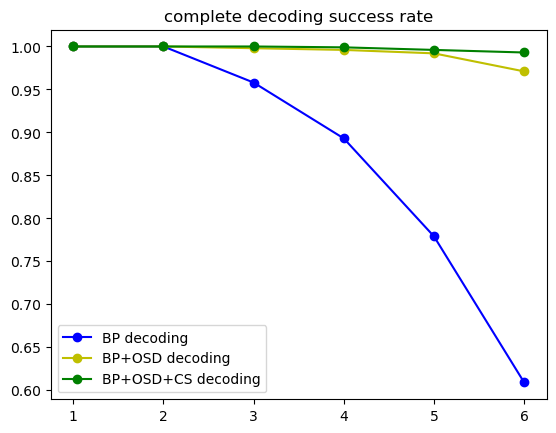

For LDPC with 76 parity check variables, 114 encoded logical bits:
BP DECODING
time for 0.005: 11.3081
time for 0.01: 17.2872
time for 0.02: 26.2985
time for 0.04: 44.1555
time for 0.06: 62.7035
time for 0.08: 81.7612
time for 0.1: 89.8724
BP+OSD DECODING
time for 0.005: 12.4283
time for 0.01: 16.4676
time for 0.02: 27.0296
time for 0.04: 50.0049
time for 0.06: 78.5836
time for 0.08: 98.4064
time for 0.1: 114.6960
BP+OSD+CS DECODING
time for 0.005: 13.5044
time for 0.01: 19.1297
time for 0.02: 66.5414
time for 0.04: 198.2639
time for 0.06: 378.3543
time for 0.08: 556.1003
time for 0.1: 595.8904


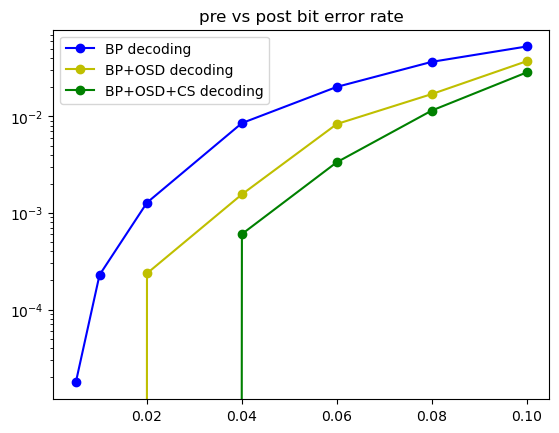

In [88]:
for M in [CM1]:
    distance_plot_test(M, verbose = 1)
    rate_plot_test(M, verbose =1)

OSD seems to be akin to codeword decoding on CM1. On the surface25 code it increases the total success rate at the expense of increasing the bit posterror rate (it gets it right more, but when it's wrong, it's more wrong).

NB: THE PAPER USES LOGICAL ERROR RATE NOT NOISE POST ERROR BIT RATE - is is the same?

## Gradio integration

In [62]:
def decimalToBinary(n):
    return bin(n).replace("0b", "")

def format_input(binstr, length):
    short = np.array([*binstr], dtype=np.int8)
    if len(short) <= length: 
        return np.pad(short, (length - len(short), 0), 'constant')
    else:
        raise ValueError("input too large")


In [82]:
description = "This is a toy syndrome-based belief propagation decoder with OSD post-processing. Pick an input number, error distance and encoding. \
Your number will convert to binary, then encode, then be corrupted by your error distance, then produce a syndrome used to decode the error. See the decoded result given your choice of parity-check matrix. \
The decoded result may not be the same as the encoded input string. It should just be equal up to a stabilizer.\n\n (It refreshes with every change to the input and might miss a change if the previous one is loading)"

def arr2string(arr):
    return ''.join(str(int(x)) for x in arr)

def greet(number, dist, choice):
    
    matrices = {"Big CLDPC": CM1, "Small CLDPC" : CM2, "Surface 25" : surface25, "Steane 17": pcm17}
    #outputs encoded binary, corrupted binary, syndrome, the estimated error, the recovered message binary, and an int output(which need not be the same) for a success, 
    M = matrices[choice]
    H1 = M
    G1 = generator(M)
    
    try:
        number = int(number)
    except: 
        raise ValueError("not a number")
        
    #string
    binary = arr2string(format_input(decimalToBinary(number), H1.shape[1]-H1.shape[0]))
    
    #np array
    encbin = word_gen(G1, x=format_input(binary, G1.shape[1]))
    
    #np array 
    corrupted = dist_error(encbin, dist)
    
    syndrome = np.remainder(np.dot(H1, corrupted),2)
    
    BP = syndrome_BP(H1,syndrome,30,0.02,higher = True )
    
    #np array 
    est_error, _ = BP.decoder()
    
    #np array 
    recovered = np.remainder(corrupted-est_error,2)
    
    x = solver(G1,recovered)
    # int from bin
    out = int(arr2string(x),2 )

    return (
        arr2string(encbin),
        arr2string(corrupted),
        arr2string(syndrome),
        arr2string(est_error),
        arr2string(recovered),
        out)


In [83]:
demo = gr.Interface(
    fn=greet,
    inputs=["text", 
            gr.Slider(0, 10, step = 1, label = "Error Distance"), 
            gr.Radio(["Big CLDPC", "Small CLDPC","Surface 25","Steane 17"], label="Parity-Check matrix", info="What matrix should we use?", value = 'Big CLDPC')],
    outputs=[gr.Textbox(label="Encoded Binary"), gr.Textbox(label="Corrupted Binary"),
             gr.Textbox(label="Syndrome Binary"),gr.Textbox(label="Estimated Error After Syndrome-based Belief Propagation Decoding"),
             gr.Textbox(label="Recovered Message Binary"), gr.Number(label = "Int Output")],
    theme=gr.themes.Monochrome(),
    title="Quantum Syndrome-Based Belief Propagation decoding",
    description = description, 
    allow_flagging = 'never',
    live = True

)
demo.launch( share = False)

/opt/anaconda3/lib/python3.9/site-packages/gradio/blocks.py:261: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(f"api_name {api_name} already exists, using {api_name_}")
/opt/anaconda3/lib/python3.9/site-packages/gradio/blocks.py:261: UserWarning: api_name predict already exists, using predict_2
  warnings.warn(f"api_name {api_name} already exists, using {api_name_}")


Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.
